# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


<ipython-input-5-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if False:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

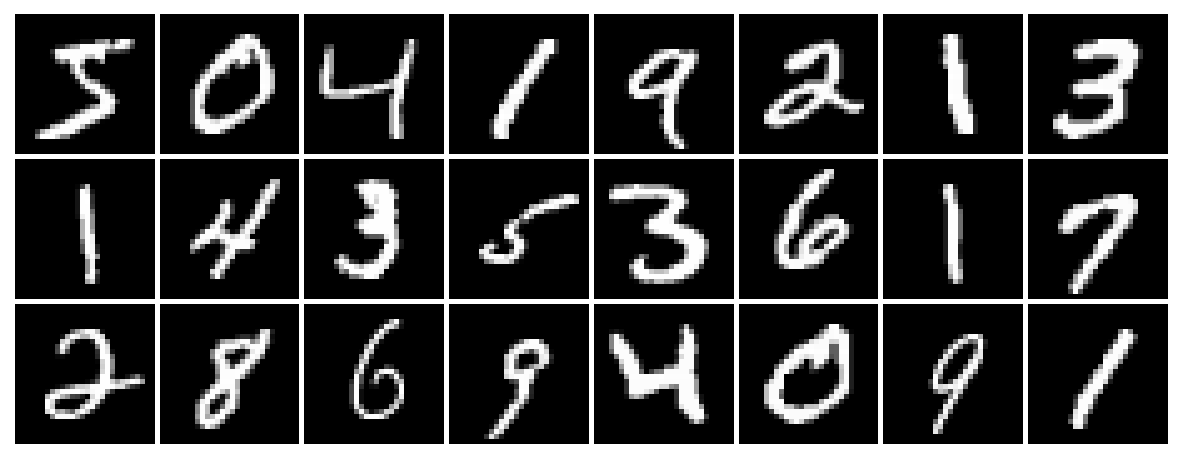

In [ ]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


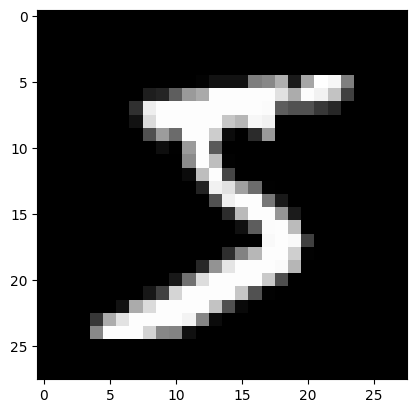

In [ ]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [7]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [ ]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.3117,  0.1493, -0.2290,  0.1344, -0.2683, -0.1976, -0.1677, -0.2549,
         -0.0110,  0.0479],
        [ 0.1216,  0.3030,  0.3029, -0.1782, -0.3136, -0.2989,  0.0559, -0.4275,
          0.0646,  0.0252],
        [-0.2011,  0.1655,  0.3027,  0.1913, -0.0883, -0.2809, -0.1298, -0.0017,
         -0.1765,  0.1350],
        [-0.2070,  0.1473, -0.1526,  0.1321,  0.0078, -0.2455, -0.2038,  0.2885,
          0.2118, -0.1585],
        [-0.2583,  0.3833,  0.1708,  0.0578, -0.2100, -0.1892, -0.0126, -0.0179,
         -0.1871, -0.0899]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [8]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [9]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-zi94c1ou
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-zi94c1ou
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=e2ddbdcd75b562b1daaf0faa56ef33dddcc5ef374c2730fbaf5f38f74abf2296
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9iffhoe/wheels/44/5a/39/48c1209682afcfc7ad8ae7b3cf7aa0ff08a72e3ac4e5931f1d
Successfully built torchviz


In [10]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.2913, grad_fn=<NllLossBackward0>)

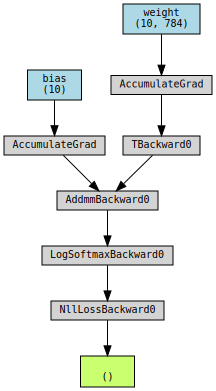

In [11]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

Epoch[1/100], loss: 2.291274, acc: 0.120117
weights: torch.Size([10, 784])


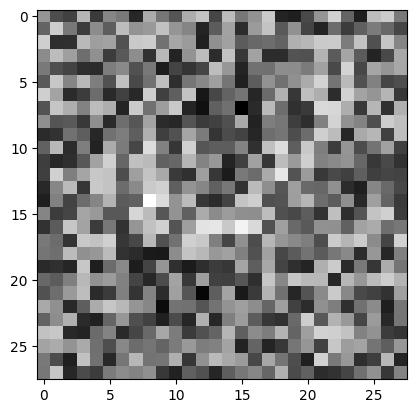

Epoch[2/100], loss: 1.822605, acc: 0.635533
weights: torch.Size([10, 784])


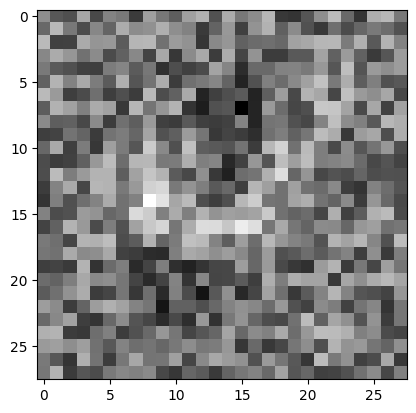

Epoch[3/100], loss: 1.508741, acc: 0.755533
weights: torch.Size([10, 784])


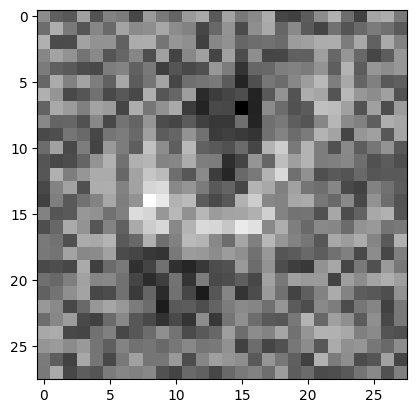

Epoch[4/100], loss: 1.298189, acc: 0.763717
weights: torch.Size([10, 784])


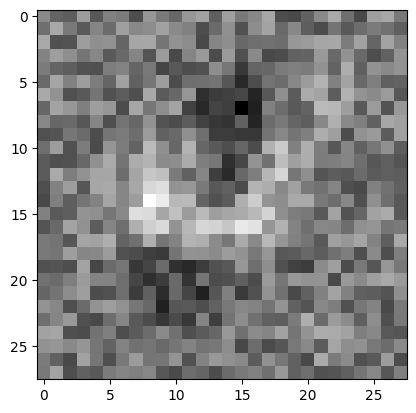

Epoch[5/100], loss: 1.153445, acc: 0.796183
weights: torch.Size([10, 784])


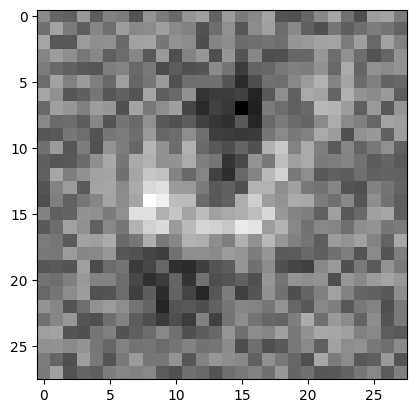

Epoch[6/100], loss: 1.046003, acc: 0.802533
weights: torch.Size([10, 784])


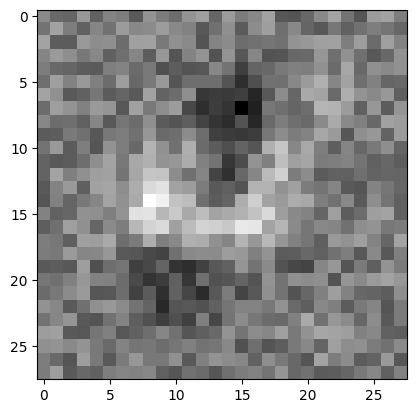

Epoch[7/100], loss: 0.966280, acc: 0.815250
weights: torch.Size([10, 784])


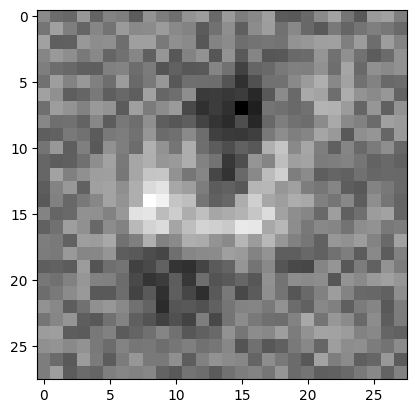

Epoch[8/100], loss: 0.904468, acc: 0.821867
weights: torch.Size([10, 784])


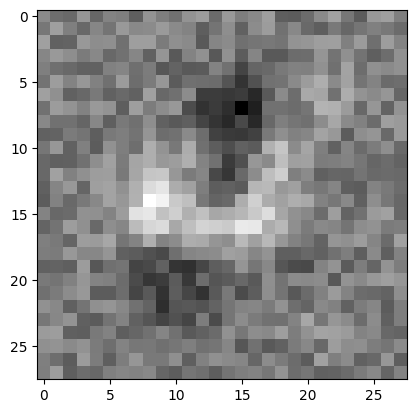

Epoch[9/100], loss: 0.855116, acc: 0.827317
weights: torch.Size([10, 784])


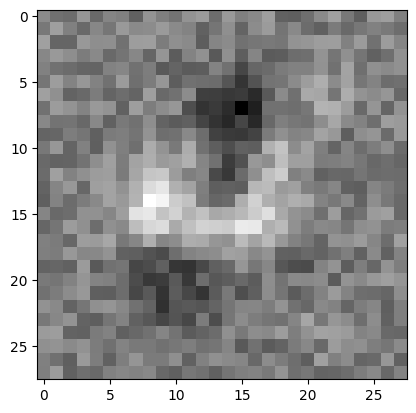

Epoch[10/100], loss: 0.814442, acc: 0.832750
weights: torch.Size([10, 784])


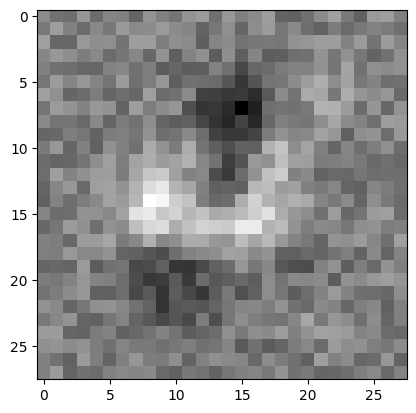

Epoch[11/100], loss: 0.780357, acc: 0.836700
weights: torch.Size([10, 784])


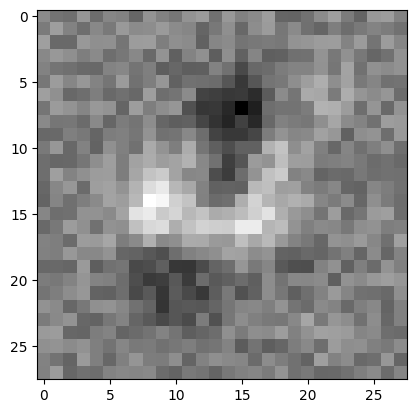

Epoch[12/100], loss: 0.751202, acc: 0.840183
weights: torch.Size([10, 784])


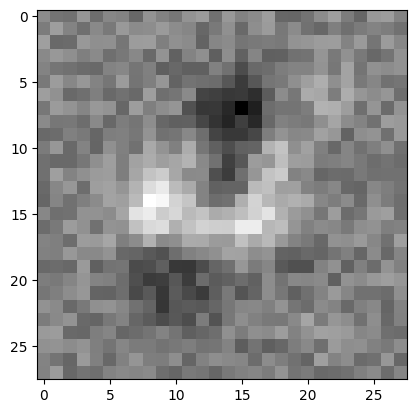

Epoch[13/100], loss: 0.726039, acc: 0.843533
weights: torch.Size([10, 784])


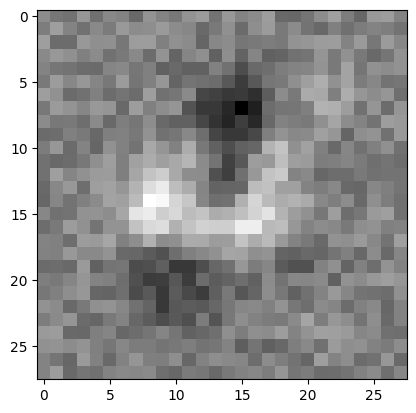

Epoch[14/100], loss: 0.704027, acc: 0.846183
weights: torch.Size([10, 784])


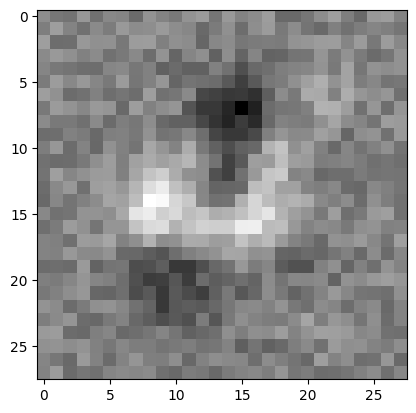

Epoch[15/100], loss: 0.684613, acc: 0.848200
weights: torch.Size([10, 784])


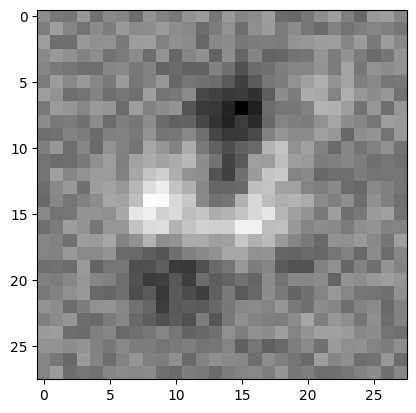

Epoch[16/100], loss: 0.667330, acc: 0.850733
weights: torch.Size([10, 784])


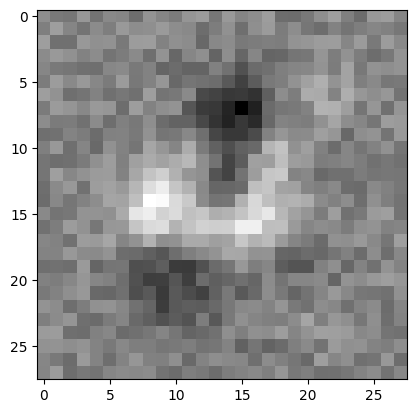

Epoch[17/100], loss: 0.651828, acc: 0.852667
weights: torch.Size([10, 784])


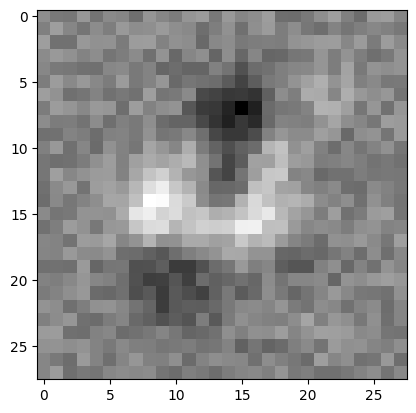

Epoch[18/100], loss: 0.637827, acc: 0.854650
weights: torch.Size([10, 784])


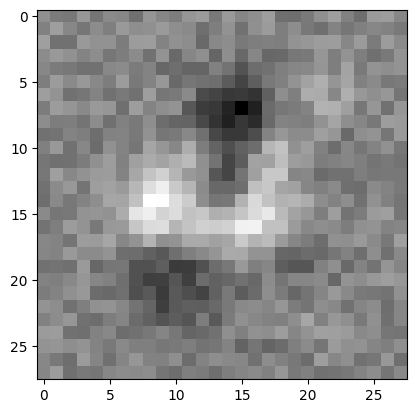

Epoch[19/100], loss: 0.625105, acc: 0.856617
weights: torch.Size([10, 784])


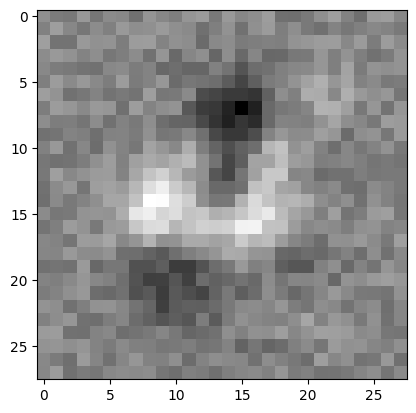

Epoch[20/100], loss: 0.613483, acc: 0.858200
weights: torch.Size([10, 784])


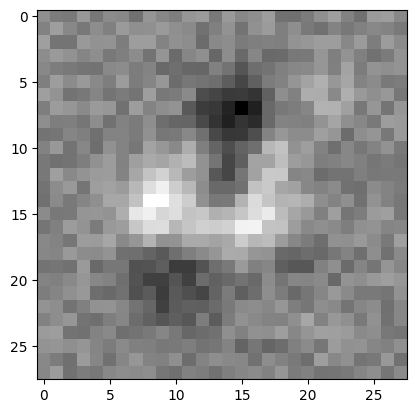

Epoch[21/100], loss: 0.602815, acc: 0.859767
weights: torch.Size([10, 784])


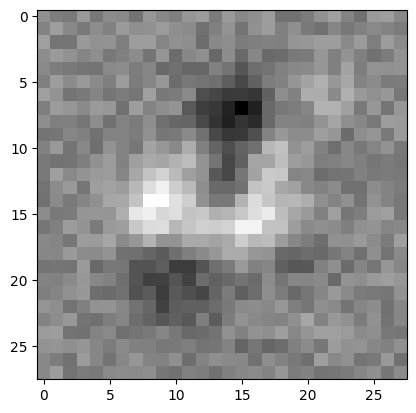

Epoch[22/100], loss: 0.592980, acc: 0.860850
weights: torch.Size([10, 784])


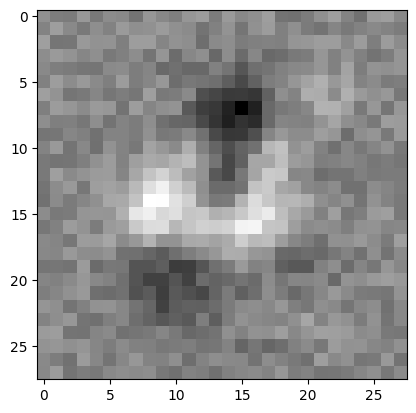

Epoch[23/100], loss: 0.583879, acc: 0.862067
weights: torch.Size([10, 784])


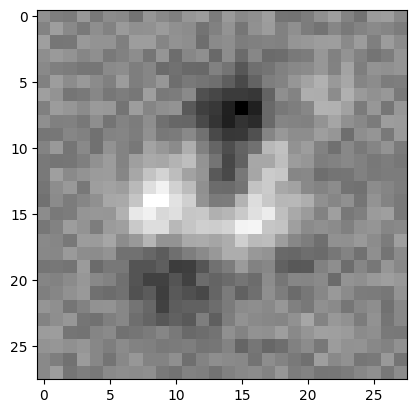

Epoch[24/100], loss: 0.575427, acc: 0.863317
weights: torch.Size([10, 784])


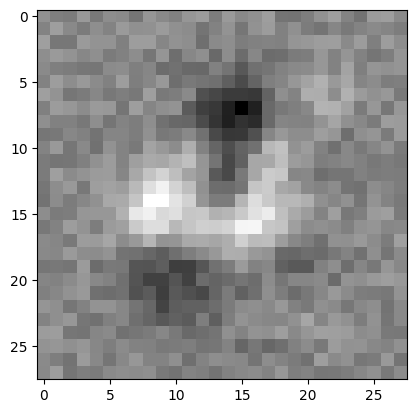

Epoch[25/100], loss: 0.567552, acc: 0.864750
weights: torch.Size([10, 784])


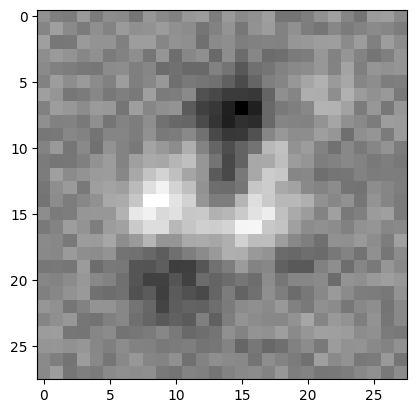

Epoch[26/100], loss: 0.560193, acc: 0.865517
weights: torch.Size([10, 784])


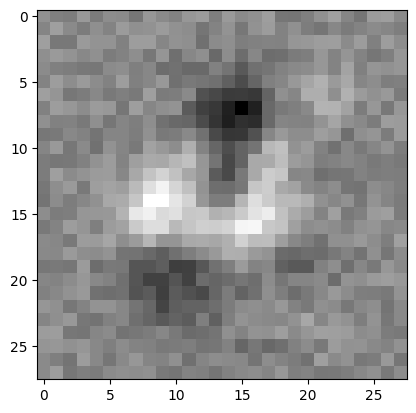

Epoch[27/100], loss: 0.553297, acc: 0.866167
weights: torch.Size([10, 784])


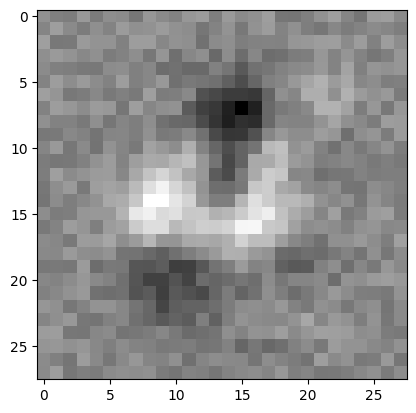

Epoch[28/100], loss: 0.546819, acc: 0.867050
weights: torch.Size([10, 784])


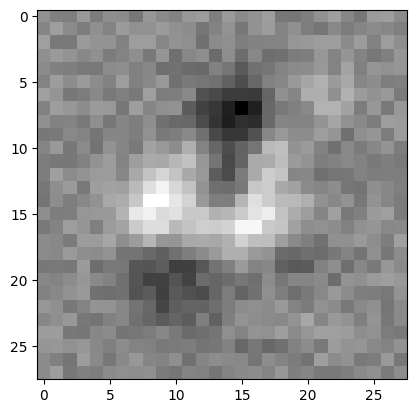

Epoch[29/100], loss: 0.540718, acc: 0.867933
weights: torch.Size([10, 784])


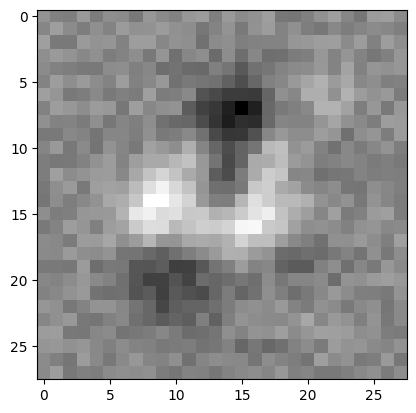

Epoch[30/100], loss: 0.534962, acc: 0.868900
weights: torch.Size([10, 784])


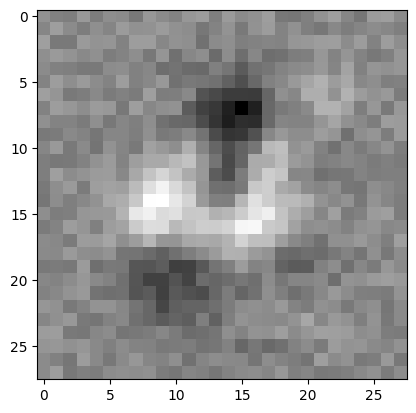

Epoch[31/100], loss: 0.529518, acc: 0.869750
weights: torch.Size([10, 784])


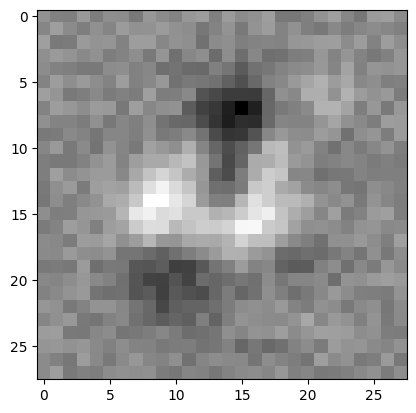

Epoch[32/100], loss: 0.524361, acc: 0.870850
weights: torch.Size([10, 784])


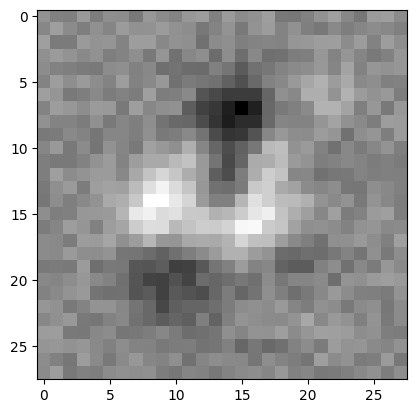

Epoch[33/100], loss: 0.519466, acc: 0.871600
weights: torch.Size([10, 784])


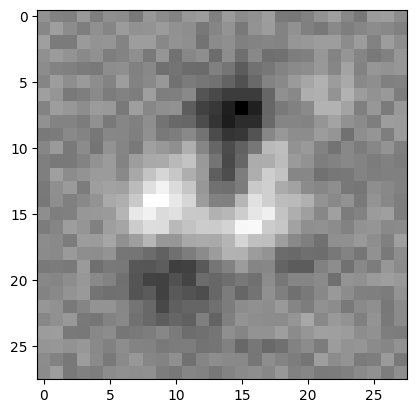

Epoch[34/100], loss: 0.514813, acc: 0.872550
weights: torch.Size([10, 784])


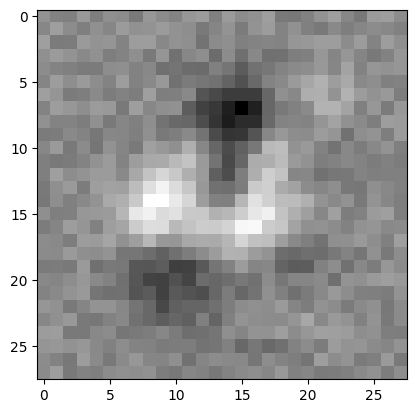

Epoch[35/100], loss: 0.510382, acc: 0.873167
weights: torch.Size([10, 784])


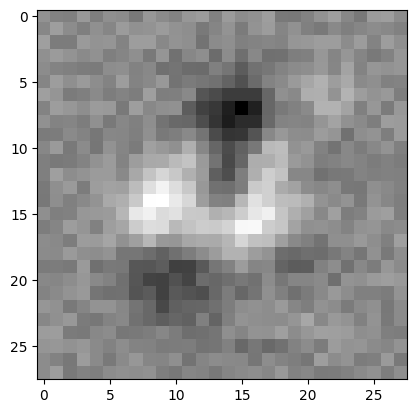

Epoch[36/100], loss: 0.506156, acc: 0.873750
weights: torch.Size([10, 784])


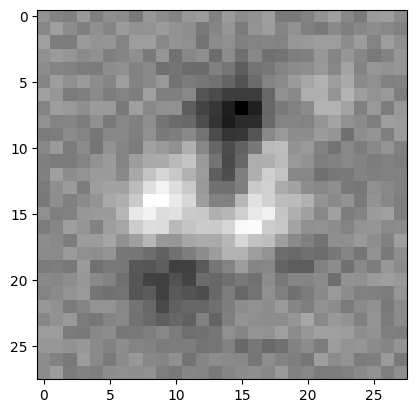

Epoch[37/100], loss: 0.502121, acc: 0.874383
weights: torch.Size([10, 784])


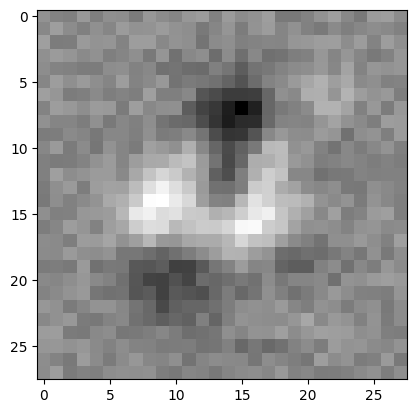

Epoch[38/100], loss: 0.498262, acc: 0.874933
weights: torch.Size([10, 784])


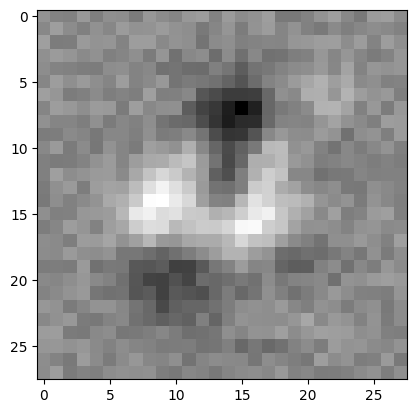

Epoch[39/100], loss: 0.494568, acc: 0.875267
weights: torch.Size([10, 784])


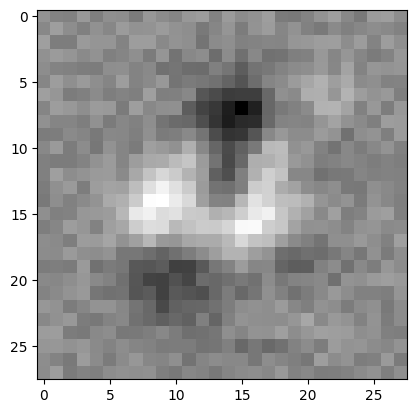

Epoch[40/100], loss: 0.491028, acc: 0.875800
weights: torch.Size([10, 784])


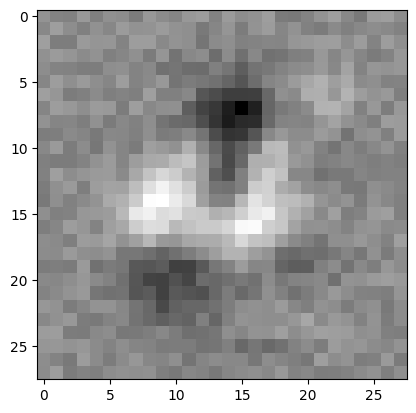

Epoch[41/100], loss: 0.487630, acc: 0.876333
weights: torch.Size([10, 784])


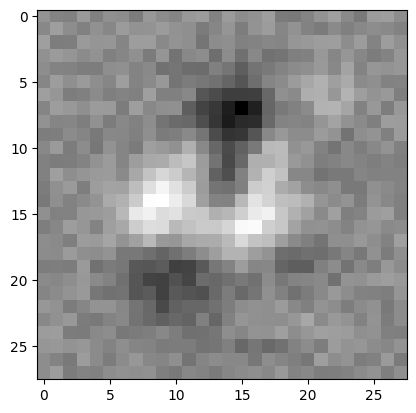

Epoch[42/100], loss: 0.484365, acc: 0.877033
weights: torch.Size([10, 784])


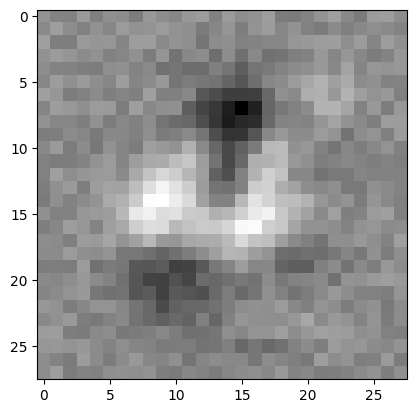

Epoch[43/100], loss: 0.481227, acc: 0.877650
weights: torch.Size([10, 784])


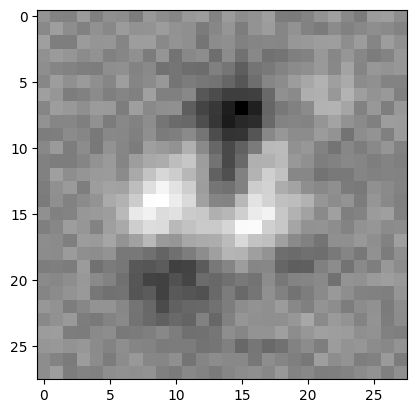

Epoch[44/100], loss: 0.478205, acc: 0.878050
weights: torch.Size([10, 784])


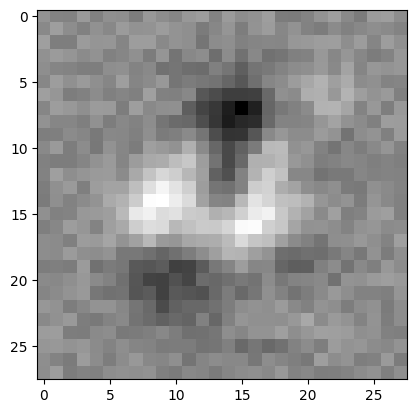

Epoch[45/100], loss: 0.475294, acc: 0.878617
weights: torch.Size([10, 784])


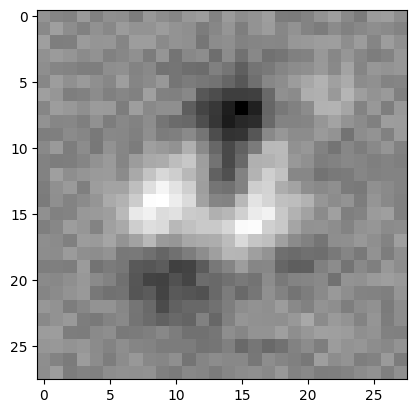

Epoch[46/100], loss: 0.472488, acc: 0.878967
weights: torch.Size([10, 784])


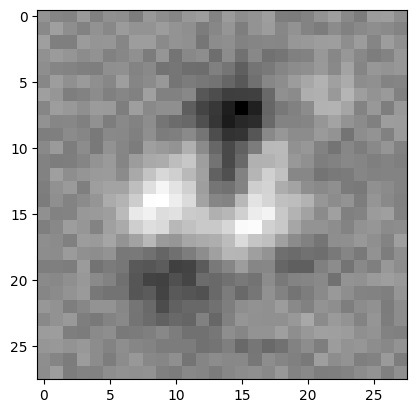

Epoch[47/100], loss: 0.469779, acc: 0.879450
weights: torch.Size([10, 784])


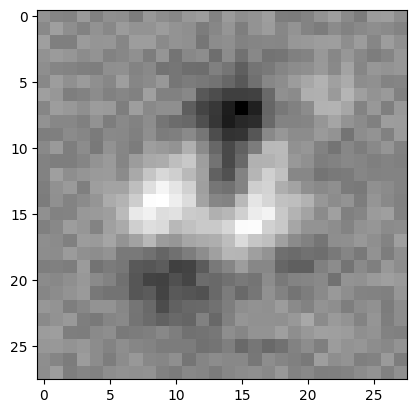

Epoch[48/100], loss: 0.467162, acc: 0.880083
weights: torch.Size([10, 784])


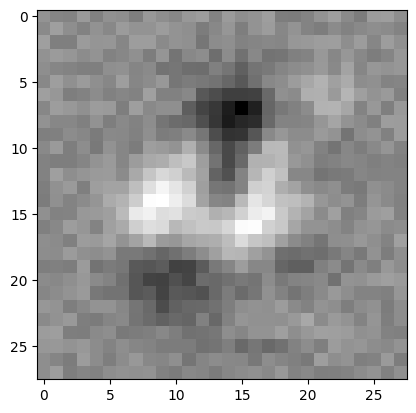

Epoch[49/100], loss: 0.464633, acc: 0.880667
weights: torch.Size([10, 784])


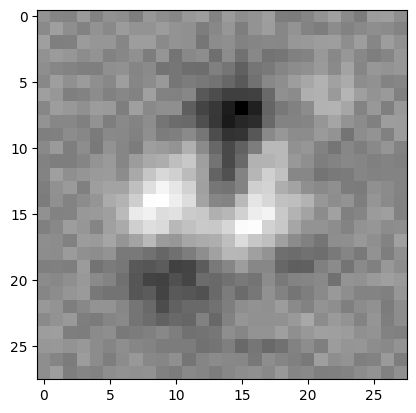

Epoch[50/100], loss: 0.462187, acc: 0.881233
weights: torch.Size([10, 784])


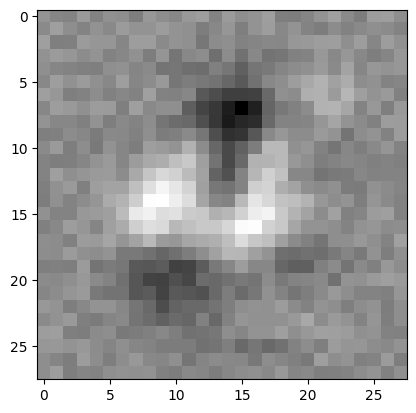

Epoch[51/100], loss: 0.459819, acc: 0.881750
weights: torch.Size([10, 784])


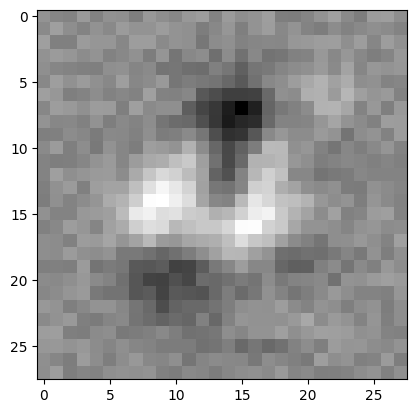

Epoch[52/100], loss: 0.457525, acc: 0.882100
weights: torch.Size([10, 784])


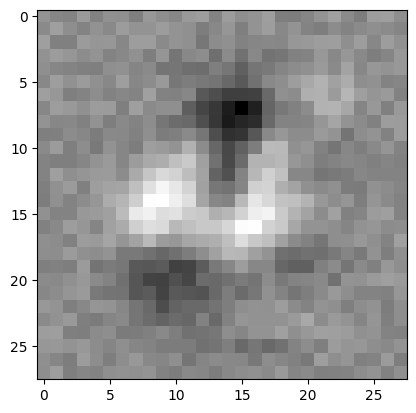

Epoch[53/100], loss: 0.455301, acc: 0.882400
weights: torch.Size([10, 784])


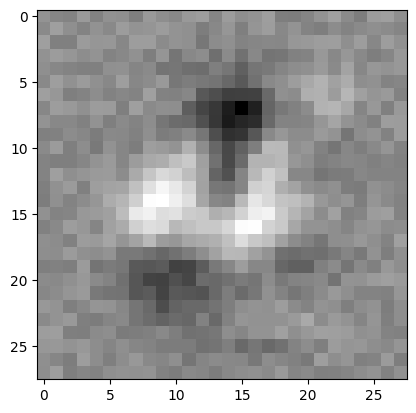

Epoch[54/100], loss: 0.453144, acc: 0.882583
weights: torch.Size([10, 784])


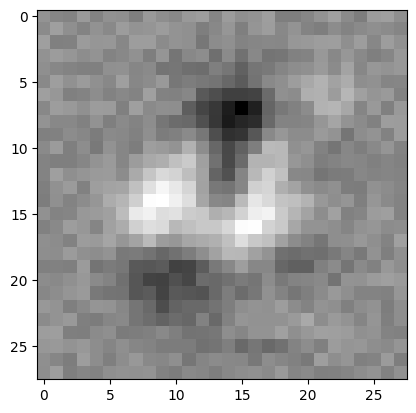

Epoch[55/100], loss: 0.451051, acc: 0.882800
weights: torch.Size([10, 784])


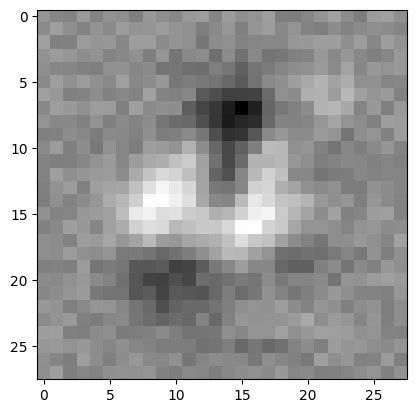

Epoch[56/100], loss: 0.449019, acc: 0.883283
weights: torch.Size([10, 784])


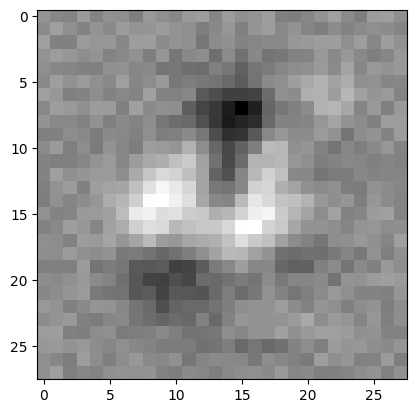

Epoch[57/100], loss: 0.447044, acc: 0.883700
weights: torch.Size([10, 784])


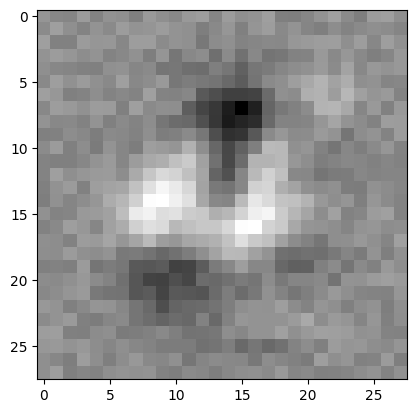

Epoch[58/100], loss: 0.445124, acc: 0.883983
weights: torch.Size([10, 784])


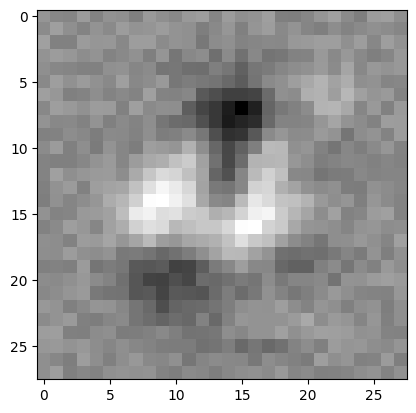

Epoch[59/100], loss: 0.443257, acc: 0.884200
weights: torch.Size([10, 784])


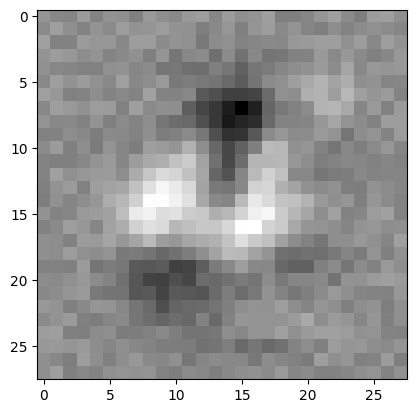

Epoch[60/100], loss: 0.441440, acc: 0.884550
weights: torch.Size([10, 784])


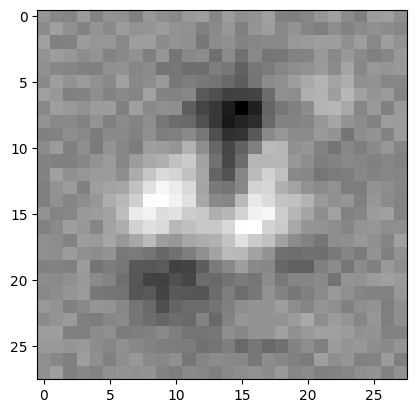

Epoch[61/100], loss: 0.439671, acc: 0.885033
weights: torch.Size([10, 784])


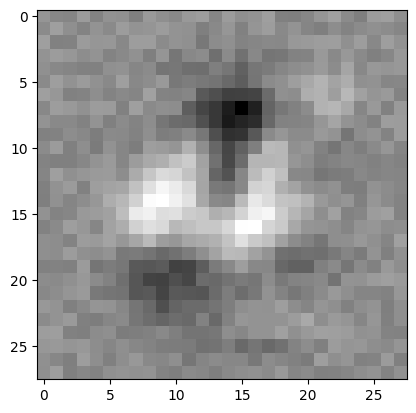

Epoch[62/100], loss: 0.437948, acc: 0.885267
weights: torch.Size([10, 784])


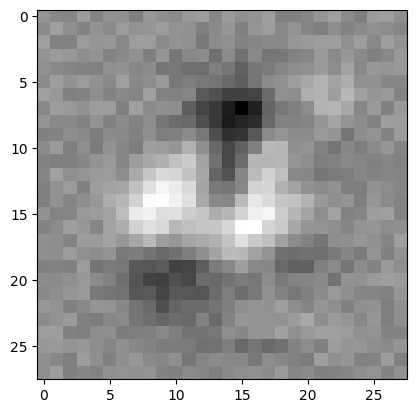

Epoch[63/100], loss: 0.436269, acc: 0.885483
weights: torch.Size([10, 784])


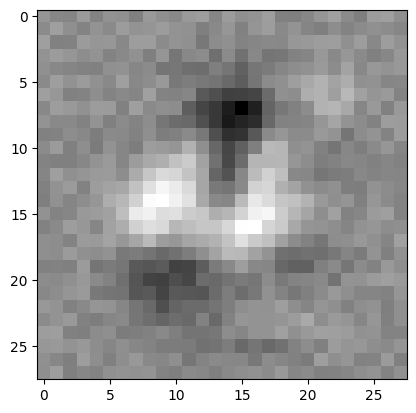

Epoch[64/100], loss: 0.434632, acc: 0.885750
weights: torch.Size([10, 784])


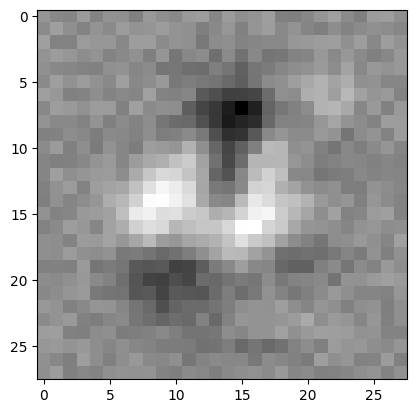

Epoch[65/100], loss: 0.433036, acc: 0.886067
weights: torch.Size([10, 784])


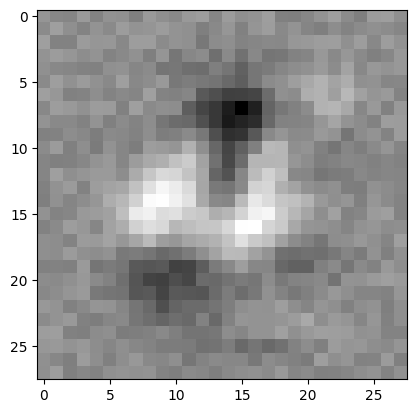

Epoch[66/100], loss: 0.431478, acc: 0.886467
weights: torch.Size([10, 784])


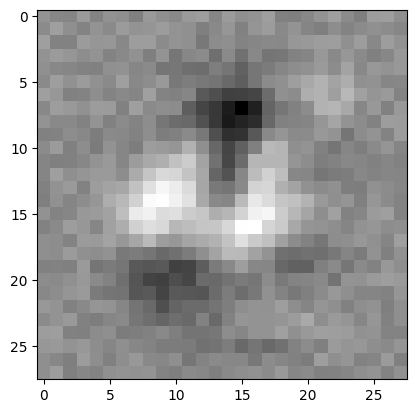

Epoch[67/100], loss: 0.429957, acc: 0.886800
weights: torch.Size([10, 784])


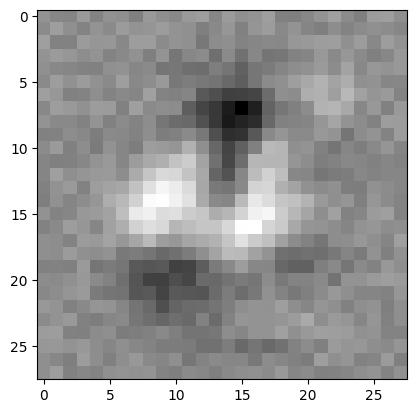

Epoch[68/100], loss: 0.428472, acc: 0.887000
weights: torch.Size([10, 784])


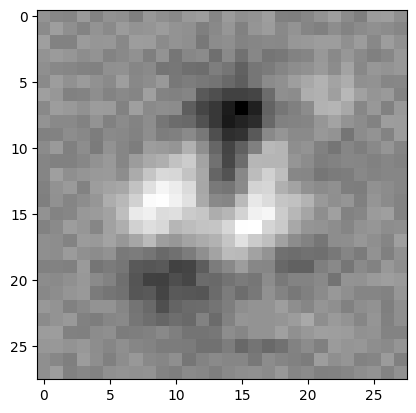

Epoch[69/100], loss: 0.427022, acc: 0.887283
weights: torch.Size([10, 784])


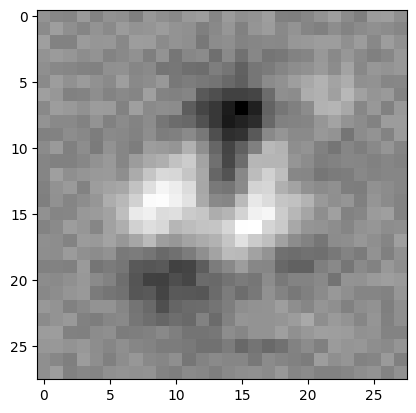

Epoch[70/100], loss: 0.425605, acc: 0.887517
weights: torch.Size([10, 784])


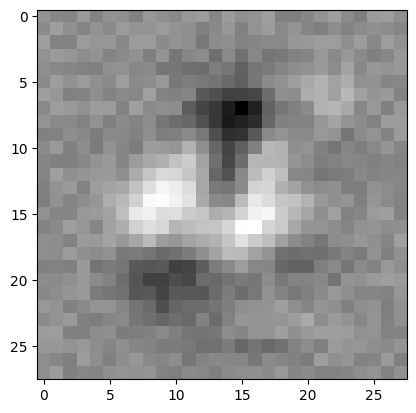

Epoch[71/100], loss: 0.424219, acc: 0.887800
weights: torch.Size([10, 784])


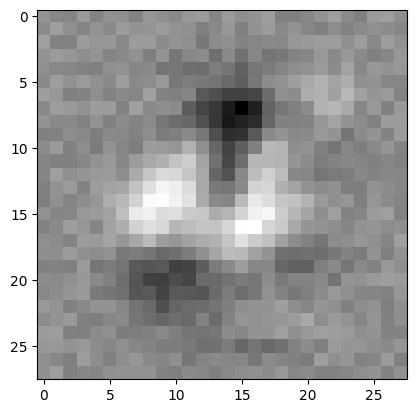

Epoch[72/100], loss: 0.422864, acc: 0.887983
weights: torch.Size([10, 784])


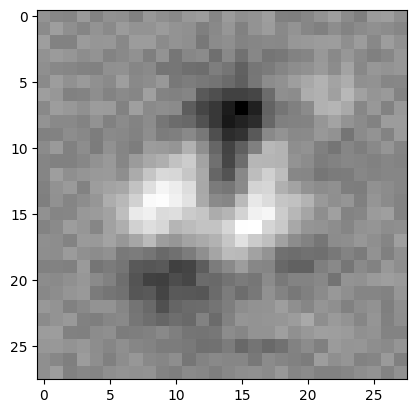

Epoch[73/100], loss: 0.421539, acc: 0.888217
weights: torch.Size([10, 784])


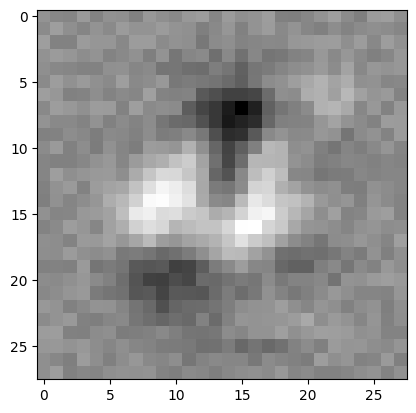

Epoch[74/100], loss: 0.420242, acc: 0.888450
weights: torch.Size([10, 784])


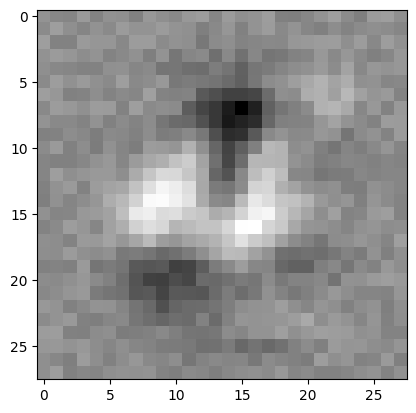

Epoch[75/100], loss: 0.418972, acc: 0.888633
weights: torch.Size([10, 784])


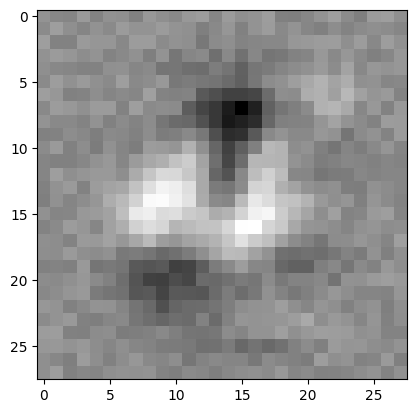

Epoch[76/100], loss: 0.417729, acc: 0.888917
weights: torch.Size([10, 784])


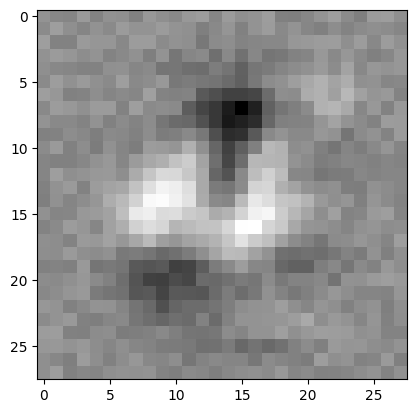

Epoch[77/100], loss: 0.416512, acc: 0.889167
weights: torch.Size([10, 784])


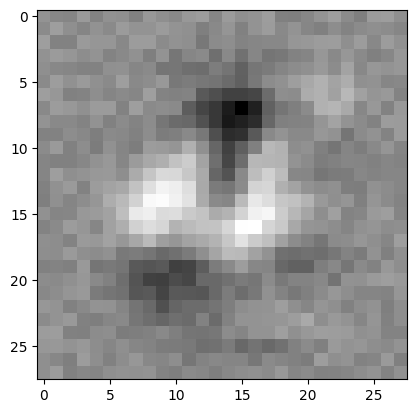

Epoch[78/100], loss: 0.415320, acc: 0.889483
weights: torch.Size([10, 784])


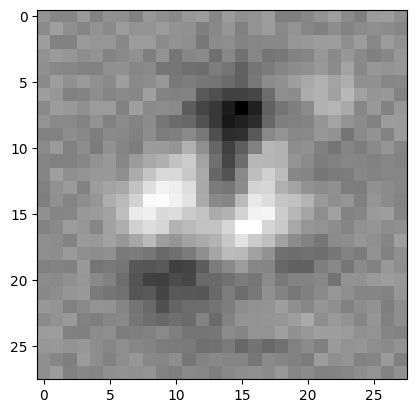

Epoch[79/100], loss: 0.414151, acc: 0.889617
weights: torch.Size([10, 784])


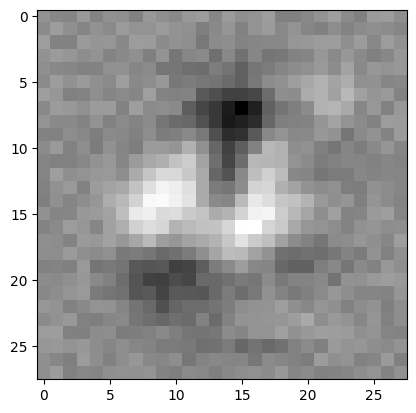

Epoch[80/100], loss: 0.413005, acc: 0.889867
weights: torch.Size([10, 784])


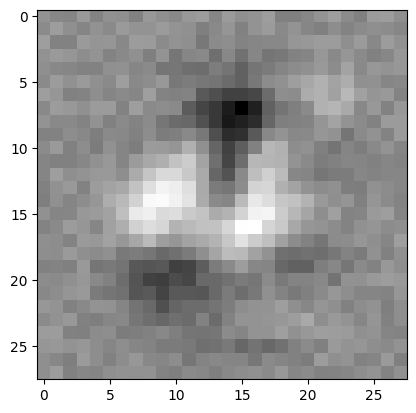

Epoch[81/100], loss: 0.411882, acc: 0.890033
weights: torch.Size([10, 784])


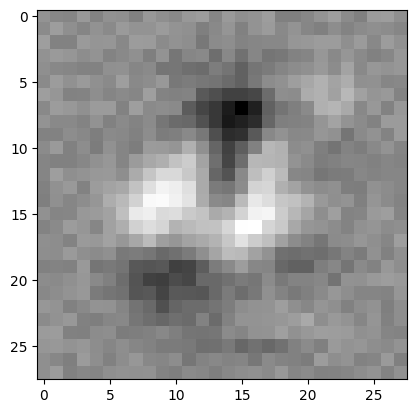

Epoch[82/100], loss: 0.410780, acc: 0.890233
weights: torch.Size([10, 784])


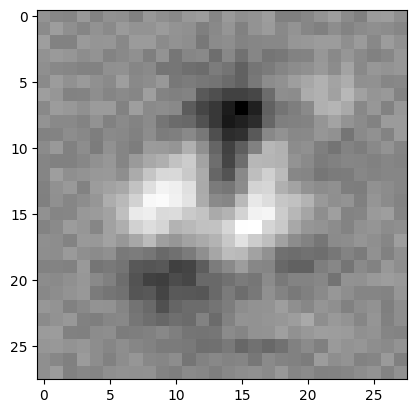

Epoch[83/100], loss: 0.409699, acc: 0.890367
weights: torch.Size([10, 784])


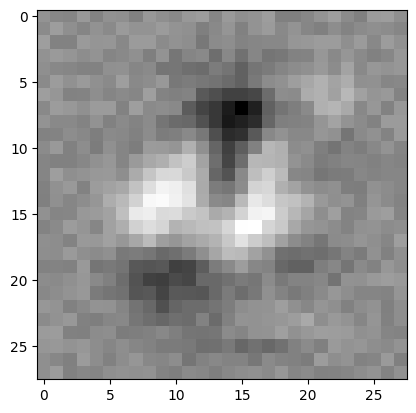

Epoch[84/100], loss: 0.408639, acc: 0.890617
weights: torch.Size([10, 784])


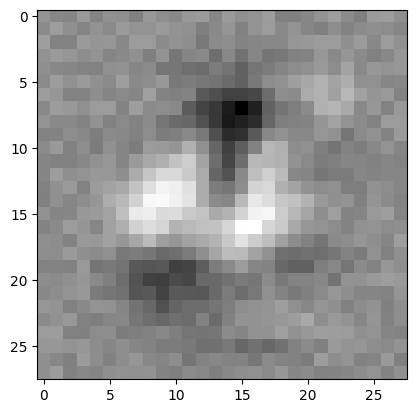

Epoch[85/100], loss: 0.407598, acc: 0.890833
weights: torch.Size([10, 784])


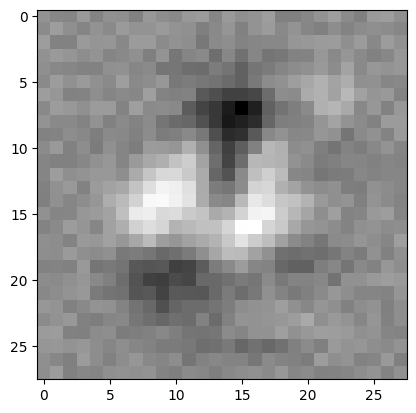

Epoch[86/100], loss: 0.406576, acc: 0.891133
weights: torch.Size([10, 784])


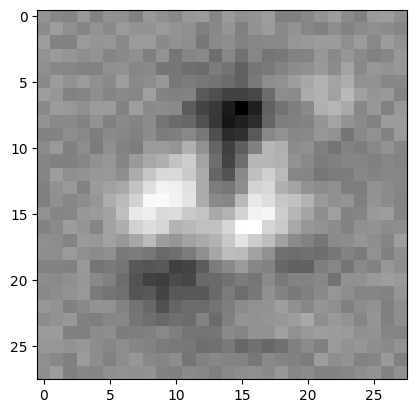

Epoch[87/100], loss: 0.405573, acc: 0.891233
weights: torch.Size([10, 784])


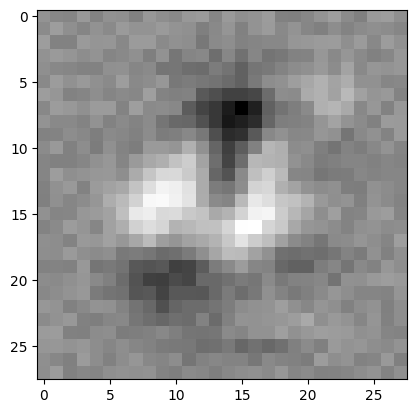

Epoch[88/100], loss: 0.404587, acc: 0.891450
weights: torch.Size([10, 784])


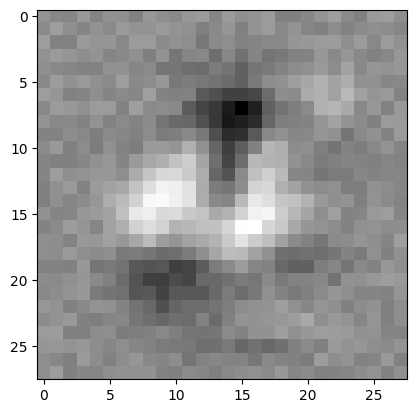

Epoch[89/100], loss: 0.403619, acc: 0.891683
weights: torch.Size([10, 784])


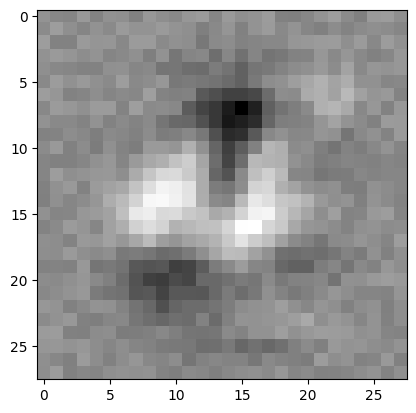

Epoch[90/100], loss: 0.402668, acc: 0.891817
weights: torch.Size([10, 784])


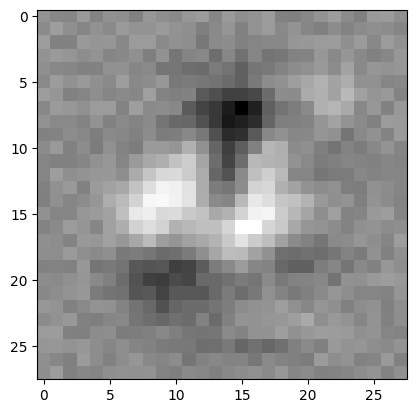

Epoch[91/100], loss: 0.401733, acc: 0.892067
weights: torch.Size([10, 784])


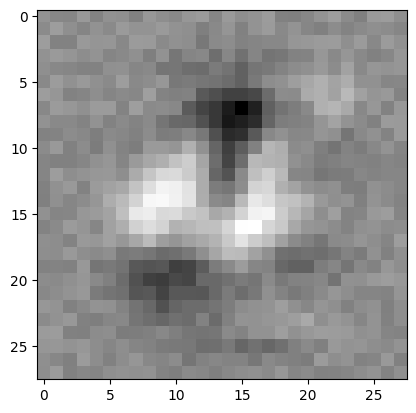

Epoch[92/100], loss: 0.400814, acc: 0.892250
weights: torch.Size([10, 784])


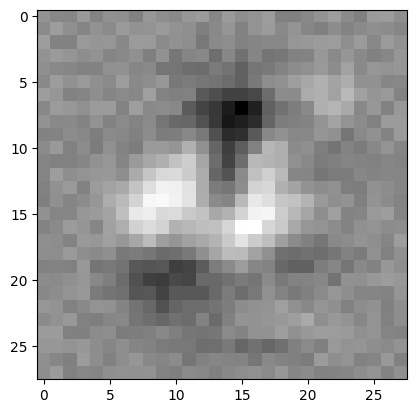

Epoch[93/100], loss: 0.399910, acc: 0.892417
weights: torch.Size([10, 784])


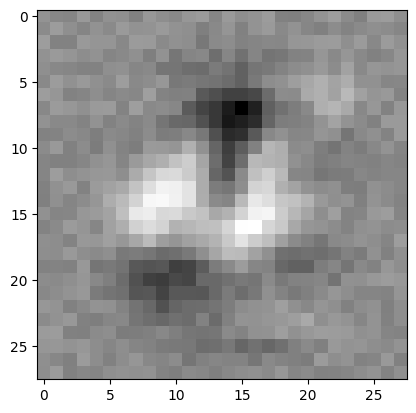

Epoch[94/100], loss: 0.399022, acc: 0.892500
weights: torch.Size([10, 784])


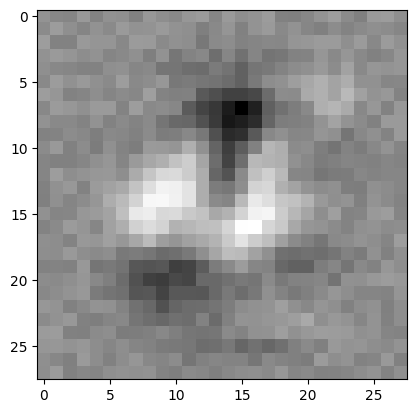

Epoch[95/100], loss: 0.398148, acc: 0.892717
weights: torch.Size([10, 784])


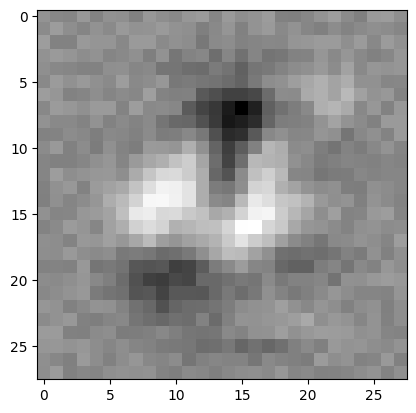

Epoch[96/100], loss: 0.397288, acc: 0.892933
weights: torch.Size([10, 784])


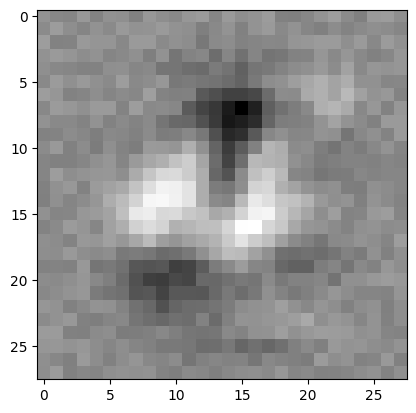

Epoch[97/100], loss: 0.396442, acc: 0.893133
weights: torch.Size([10, 784])


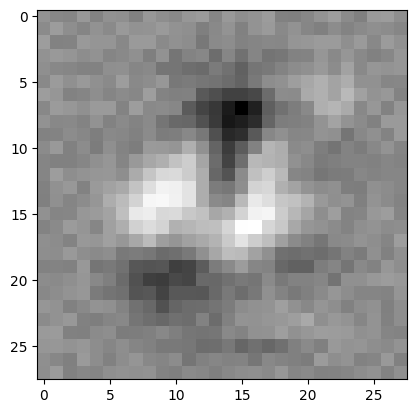

Epoch[98/100], loss: 0.395610, acc: 0.893400
weights: torch.Size([10, 784])


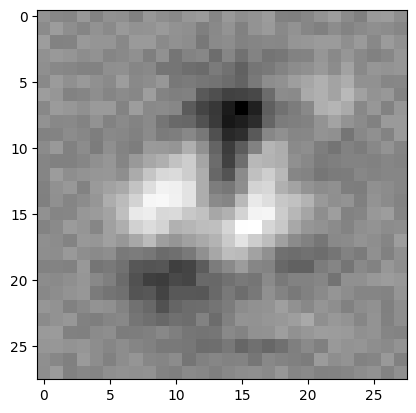

Epoch[99/100], loss: 0.394791, acc: 0.893567
weights: torch.Size([10, 784])


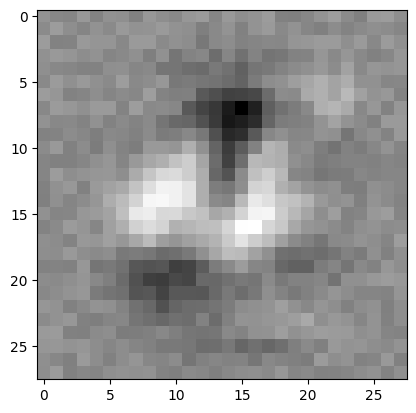

Epoch[100/100], loss: 0.393984, acc: 0.893717
weights: torch.Size([10, 784])


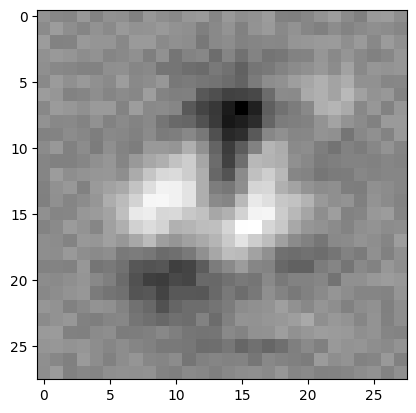

In [12]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data

    #Solução
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))

    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()


In [ ]:
print('Final loss:', loss.item())

Final loss: 0.2655509412288666


### Visualizando gráfico de perda durante o treinamento

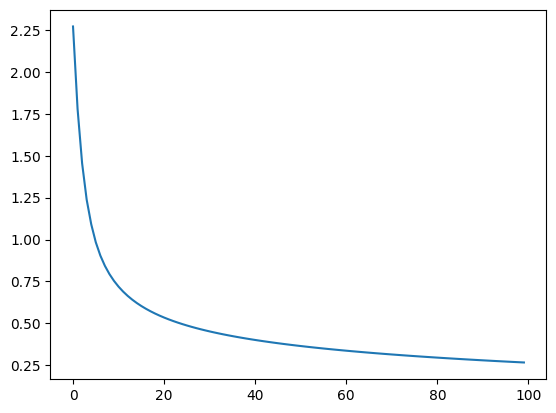

In [ ]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [ ]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.943


### Matriz de confusão com dados de treinamento e teste

In [ ]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,111,1,0,0,0,1,2,1,0
2,0,0,91,1,0,1,1,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,0,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,1,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


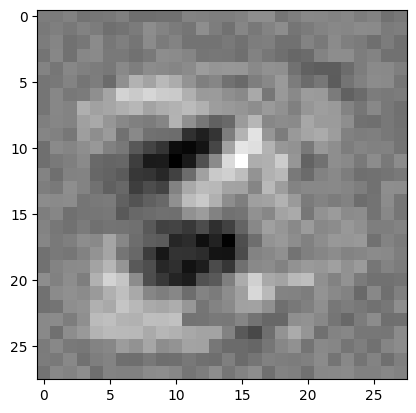

In [ ]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

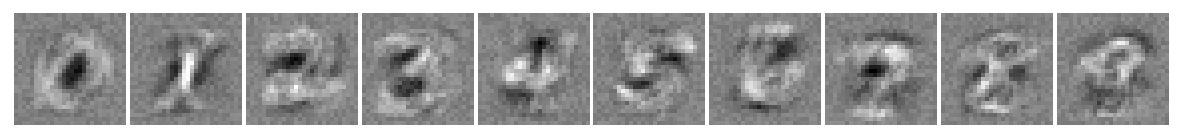

In [ ]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
    
    R: [1000, 28, 28]
2. Qual é o shape da saída da rede?
    
    R: [1000, 10]
3. Qual é o número total de parâmetros da rede, incluindo o bias?
    
    R: 28 x 28 + 10 = 794

# Aprendizados
